In [23]:
import copy
import sys
import os

from jobs.tau_sweep.aquaplanet.hottest_day_date import pot_temp_atmos

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R, lapse_dry
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots, fig_resize, update_fontsize, update_linewidth
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory
from isca_tools.thesis.lapse_theory import interp_var_at_pressure, get_bulk_lapse_rate, reconstruct_temp
from isca_tools import cesm
from isca_tools.convection.base import lcl_metpy
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from geocat.comp.interpolation import interp_hybrid_to_pressure
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [137]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['T', 'PS', 'QREFHT', 'TREFHT', 'Z3']
var_isca_dict = {'T': 'temp', 'PS': 'ps', 'QREFHT': 'sphum_2m', 'TREFHT': 'temp_2m', 'Z3': 'height'}

use_time_start = 360*2

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
is_isca_data = 'cesm' not in 'exp_dir'

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}_2m", f"k={str(tau_lw_warm).replace('.','_')}_2m"]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))
        if is_isca_data:
            # Rename isca data to same as for CESM
            ds_use = ds_use[[var_isca_dict[key] for key in var_keep]]
            ds_use = ds_use.rename_vars({v: k for k, v in var_isca_dict.items()})
        else:
            ds_use = ds_use[var_keep]
        ds += [ds_use]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        if j==0:
            p0 = float(namelist['spectral_dynamics_nml']['reference_sea_level_press'])
            sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
            hybm = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')       # sigma levels corresponding to pressure levels
            hyam = np.zeros_like(hybm)
        pbar.update(1)

pfull = ds_use.pfull
n_pressure = ds[0].pfull.size

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [138]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1)
    fig_resize(fig, 3)
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land

    if save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf")

In [139]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]}

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'


ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory

        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])

        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0))
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [140]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# quant2 is the actual quantile value rather than the average above a given quantile
ds_quant3 = {'T': np.zeros((n_kappa, n_pressure, n_lat, n_quant)),
             'Z3': np.zeros((n_kappa, n_pressure, n_lat, n_quant)),
             'PS': np.zeros((n_kappa, n_lat, n_quant)),
             'QREFHT': np.zeros((n_kappa, n_lat, n_quant)),
             'TREFHT': np.zeros((n_kappa, n_lat, n_quant))}

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        ds_quant3['TREFHT'][j] = ds_use.TREFHT.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
        for k in range(n_lat):
            for q, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_use.TREFHT.isel(lat=k), quant, 0.5, 0.5)
                ds_quant3['T'][j, :, k, q] = ds_use.T[:, k, use_ind].mean(dim='lon_time')
                ds_quant3['Z3'][j, :, k, q] = ds_use.Z3[:, k, use_ind].mean(dim='lon_time')
                ds_quant3['PS'][j, k, q] = ds_use.PS[k, use_ind].mean(dim='lon_time')
                ds_quant3['QREFHT'][j, k, q] = ds_use.QREFHT[k, use_ind].mean(dim='lon_time')
                pbar.update(1)

# Convert to dataset
coords = {"kappa": tau_lw, "lev": np.asarray(pfull)*100, "lat": ds_all[0].lat, "quant": quant_plot}
ds_quant3 = xr.Dataset({
    key: xr.DataArray(ds_quant3[key], dims=["kappa", "lev", "lat", "quant"] if key in ['T', 'Z3'] else ["kappa", "lat", "quant"],
                      coords=coords if key in ['T', 'Z3'] else {k: coords[k] for k in ["kappa", "lat", "quant"]}) for key in ds_quant3
})

# Compute T500 and Z500 from pressure info
ds_quant3['T500'] = interp_hybrid_to_pressure(ds_quant3.T, ds_quant3.PS, xr.DataArray(hyam, dims='lev'),
                                              xr.DataArray(hybm, dims='lev'), p0, np.atleast_1d(500*100), lev_dim='lev')
ds_quant3['T500'] = ds_quant3['T500'].isel(plev=0).load()
ds_quant3['Z500'] = interp_hybrid_to_pressure(ds_quant3.Z3, ds_quant3.PS, xr.DataArray(hyam, dims='lev'),
                                              xr.DataArray(hybm, dims='lev'), p0, np.atleast_1d(500*100), lev_dim='lev')
ds_quant3['Z500'] = ds_quant3['Z500'].isel(plev=0).load()

# Compute RH
ds_quant3['rh_REFHT'] = ds_quant3.QREFHT / sphum_sat(ds_quant3.TREFHT, ds_quant3.PS)

# Compute epsilon = mse_surf - mse_ft_sat
ds_quant3['mse_lapse'] = moist_static_energy(ds_quant3.TREFHT, ds_quant3.QREFHT, 2) - \
                         moist_static_energy(ds_quant3.T500, sphum_sat(ds_quant3.T500, 500 * 100), ds_quant3.Z500)

  0%|          | 0/2772 [00:00<?, ?it/s]

In [141]:
# Get reference dataset to use for computing scale factor relative to
av_use = 'median'       # Use median so all go through x=50 point in graph, and easier to explain
ds_ref = {key: np.asarray([getattr(ds_all[i][key], av_use)(dim='lon_time') for i in range(n_kappa)])
          for key in ['PS', 'QREFHT', 'TREFHT']}
ds_ref['rh_REFHT'] = ds_ref['QREFHT'] / sphum_sat(ds_ref['TREFHT'], ds_ref['PS'])
ds_ref['rh_REFHT'][1] = ds_ref['rh_REFHT'][0]               # set rh change to 0 in reference dataset
ds_ref['mse_lapse'] = np.zeros_like(ds_ref['PS'])
ds_ref['z_approx_error'] = np.zeros_like(ds_ref['PS'])
ds_ref = xr.Dataset({key: xr.DataArray(ds_ref[key], dims=["kappa", "lat"],
                                       coords={k: coords[k] for k in ["kappa", "lat"]}) for key in ds_ref})

In [142]:
# delta_temp_quant_theory[0] will be all zeros and never used, but helpful to keep this shape
sf_simulated = np.diff(ds_quant3.TREFHT.values, axis=0).squeeze() / np.diff(ds_ref.TREFHT.values, axis=0).squeeze()[:, np.newaxis]
sf_theory = np.zeros((n_lat, n_quant))
sf_theory_cont = {key: np.zeros((n_lat, n_quant)) for key in ['temp_ft_change', 'r_change', 'cape_change',
                                                                            'temp_anom', 'r_anom']}

for i in tqdm(range(n_lat)):
    sf_theory[i], gamma_use, _, var = \
            get_scale_factor_theory(ds_ref.isel(lat=i).TREFHT.values, ds_quant3.isel(lat=i).TREFHT.values, ds_ref.isel(lat=i).rh_REFHT.values,
                                    ds_quant3.isel(lat=i).rh_REFHT.values,
                                    ds_quant3.isel(lat=i).T500.values, ds_quant3.isel(lat=i).mse_lapse.values, float(ds_ref.isel(lat=i, kappa=0).PS),
                                    500*100, ds_ref.isel(lat=i).mse_lapse.values, ds_ref.isel(lat=i).z_approx_error.values,
                                    include_non_linear=False, cape_form=True, pressure_surf_quant=ds_quant3.isel(lat=i).PS.values)
    for key in sf_theory_cont:
        sf_theory_cont[key][i] = var[key]

  0%|          | 0/14 [00:00<?, ?it/s]

In [143]:
quant_median_ind = np.where(quant_plot==50)[0][0]

def plot_sf(var, ax_lat=0, lat_weights=lat_weights, ax_quant=1, norm_by_median=True, median_ind=quant_median_ind):
    if norm_by_median:
        return np.average(var - np.take(var, indices=[median_ind], axis=ax_quant) + 1, axis=ax_lat, weights=lat_weights)
    else:
        return np.average(var, axis=ax_lat, weights=lat_weights)

colors_cont = {'temp_anom': 'C3', 'r_anom': 'C4',
               'r_change': 'C0', 'temp_ft_change': 'C2', 'cape_change': 'C1'}
ax_linewidth = plt.rcParams['axes.linewidth']

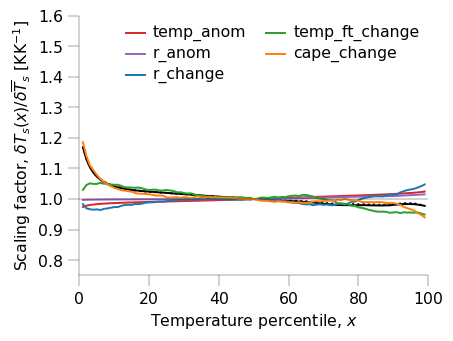

In [144]:
im_sz = 4.5
norm_median = True     # force all lines through x=50
save_sf_theory_fig = False
fig, ax = plt.subplots(1,1)
fig_resize(fig, im_sz)
ax.plot(quant_plot, plot_sf(sf_simulated, norm_by_median=norm_median), color='k')
ax.plot(quant_plot, plot_sf(sf_theory, norm_by_median=norm_median), color='k', linestyle=':')
for k, key2 in enumerate(colors_cont):
    ax.plot(quant_plot, plot_sf(sf_theory_cont[key2], norm_by_median=norm_median) + int(not norm_median and 'ft' not in key2),
            color=colors_cont[key2], label=key2)
ax.set_xlim(0,100)
# ylim_sf = [0.8, 1.2]                    # use here and for fixed evap figure below
# ytick_sf = np.arange(0.8, 1.3, 0.1)     # use here and for fixed evap figure below
ax.set_ylim([0.75, 1.6])
# ax.set_yticks(ytick_sf)
ax.set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')
ax.set_xlabel(percentile_label)
update_linewidth(fig)
ax.legend(ncol=2)
update_fontsize(fig)
ax.axhline(1, linewidth=ax_linewidth, color='k')
ax.tick_params(length=8, direction='out')

plt.show()
if save_sf_theory_fig:
    isca_tools.savefig(fig)

In [145]:
# Compute LCL from averaged quantities
ds_quant3['p_lcl'], ds_quant3['T_lcl'] = lcl_metpy(ds_quant3.TREFHT, ds_quant3.QREFHT, ds_quant3.PS)
ds_quant3['Z3_lcl'] = 2 + (ds_quant3.TREFHT - ds_quant3.T_lcl) / lapse_dry          # 2 because REFHT is at 2m

# Get environmental info on pressure levels from average profile
def get_TZp_at_lcl(ds_prof, p_lcl, p_surf):
    ds_interp = interp_var_at_pressure(ds_prof, p_lcl, p_surf, xr.DataArray(hyam, dims='lev'),
                                       xr.DataArray(hybm, dims='lev'), p0)
    return ds_interp.T, ds_interp.Z3, ds_interp.plev
ds_quant3['T_at_lcl'], ds_quant3['Z3_at_lcl'], ds_quant3['p_at_lcl'] = get_TZp_at_lcl(ds_quant3[['T', 'Z3']], ds_quant3.p_lcl, ds_quant3.PS)
ds_quant3 = ds_quant3.load()

ds_quant3['lapse_below_lcl'] = get_bulk_lapse_rate(ds_quant3.TREFHT, ds_quant3.T_at_lcl, ds_quant3.PS, ds_quant3.p_at_lcl) * 1000
ds_quant3['lapse_above_lcl'] = get_bulk_lapse_rate(ds_quant3.T_at_lcl, ds_quant3.T500, ds_quant3.p_at_lcl, 500*100) * 1000

In [146]:
TREFHT_change_breakdown_change = {'T500': ds_quant3.T500[1]-ds_quant3.T500[0],
                                  'lapse_below_lcl': ds_quant3.lapse_below_lcl[1] - ds_quant3.lapse_below_lcl[0],
                                  'lapse_above_lcl': ds_quant3.lapse_above_lcl[1] - ds_quant3.lapse_above_lcl[0],
                                  'p_lcl': ds_quant3.p_lcl[1]/ds_quant3.PS[1] - ds_quant3.p_lcl[0]/ds_quant3.PS[0],
                                  'p_s': float(ds_quant3.plev)/ds_quant3.PS[1] - float(ds_quant3.plev)/ds_quant3.PS[0]}
TREFHT_change_breakdown_sensitivity = {'T500': (ds_quant3.TREFHT/ds_quant3.T500)[0],
                                       'lapse_below_lcl': -ds_quant3.TREFHT[0] * np.log(ds_quant3.p_lcl/ds_quant3.PS)[0] * R/g / 1000,
                                       'lapse_above_lcl': ds_quant3.TREFHT[0] * np.log(ds_quant3.p_lcl/float(ds_quant3.plev))[0] * R/g / 1000,
                                       'p_lcl': R/g * (ds_quant3.lapse_above_lcl-ds_quant3.lapse_below_lcl)[0]/1000 * (
                                               ds_quant3.PS/ds_quant3.p_lcl * ds_quant3.TREFHT)[0],
                                       'p_s': -R/g * ds_quant3.lapse_above_lcl[0]/1000 * (ds_quant3.PS/float(ds_quant3.plev) * ds_quant3.TREFHT)[0]}
for key in TREFHT_change_breakdown_change:
    TREFHT_change_breakdown_change[key] = TREFHT_change_breakdown_change[key].transpose("lat", "quant")
    TREFHT_change_breakdown_sensitivity[key] = TREFHT_change_breakdown_sensitivity[key].transpose("lat", "quant")
TREFHT_change_breakdown_cont = {key: TREFHT_change_breakdown_change[key] * TREFHT_change_breakdown_sensitivity[key]
                              for key in TREFHT_change_breakdown_change}
TREFHT_change_theory = sum(TREFHT_change_breakdown_cont.values())

colors_cont_lapse = {'p_s': 'C3', 'lapse_below_lcl': 'C4',
               'p_lcl': 'C0', 'T500': 'C2', 'lapse_above_lcl': 'C1'}

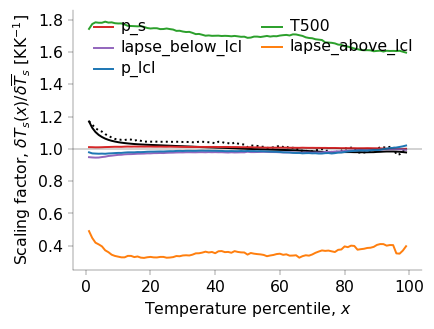

In [147]:
im_sz = 4.5
norm_median = False    # force all lines through x=50
save_sf_theory_fig = False
fig, ax = plt.subplots(1,1)
fig_resize(fig, im_sz)
ax.plot(quant_plot, plot_sf(sf_simulated, norm_by_median=norm_median), color='k')
ax.plot(quant_plot, plot_sf((TREFHT_change_theory/np.diff(ds_ref.TREFHT.values, axis=0).squeeze()[:, np.newaxis]).values, norm_by_median=norm_median), color='k', linestyle=':')
for k, key2 in enumerate(colors_cont_lapse):
    ax.plot(quant_plot, plot_sf(TREFHT_change_breakdown_cont[key2].values/np.diff(ds_ref.TREFHT.values, axis=0).squeeze()[:, np.newaxis]
                                + int(not norm_median and '500' not in key2),
                                norm_by_median=norm_median),
            color=colors_cont_lapse[key2], label=key2)
# ax.set_xlim(0,100)
# # ylim_sf = [0.8, 1.2]                    # use here and for fixed evap figure below
# # ytick_sf = np.arange(0.8, 1.3, 0.1)     # use here and for fixed evap figure below
# ax.set_ylim([0.75, 1.6])
# # ax.set_yticks(ytick_sf)
ax.set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')
ax.set_xlabel(percentile_label)
update_linewidth(fig)
ax.legend(ncol=2)
update_fontsize(fig)
ax.axhline(1, linewidth=ax_linewidth, color='k')
# ax.tick_params(length=8, direction='out')

plt.show()
if save_sf_theory_fig:
    isca_tools.savefig(fig)

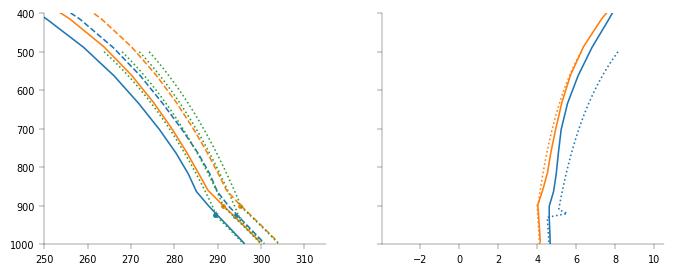

In [151]:
lat_show = 0
quant_show = [50, 99]
fig, ax = plt.subplots(1, 2, sharey=True)
fig_resize(fig, 8)
show_conv_prof = True
for j in range(len(quant_show)):
    ds_use = [ds_quant3.sel(quant=quant_show[j], lat=lat_show, kappa=tau_lw[i], method='nearest') for i in range(n_kappa)]
    p_levels_use = np.append(np.linspace(1000*100, 500*100, 51), [ds_use[0].p_at_lcl, ds_use[0].p_at_lcl])
    p_levels_use.sort()
    temp_prof_const_lapse = np.zeros((n_kappa, p_levels_use.size))
    temp_prof_conv = np.zeros((n_kappa, p_levels_use.size))
    for i in range(n_kappa):
        ax[0].plot(ds_use[i].T, float(ds_use[i].PS) * hybm/100, color=f'C{j}',
                linestyle='--' if i==1 else None)
        ax[0].scatter(ds_use[i].T_lcl, ds_use[i].p_lcl/100, color=f'C{j}')
        ax[0].scatter(ds_use[i].T_at_lcl, ds_use[i].p_at_lcl/100, color=f'C{j}', marker='+')

        # Compute profile below LCL
        ind_use = p_levels_use>=float(ds_use[i].p_at_lcl)
        temp_prof_const_lapse[i, ind_use] = reconstruct_temp(float(ds_use[i].TREFHT), p_levels_use[ind_use], p_levels_use[ind_use],
                                                             float(ds_use[i].PS), float(ds_use[i].lapse_below_lcl)/1000,
                                                             float(ds_use[i].lapse_below_lcl)/1000)
        temp_prof_conv[i, ind_use] = isca_tools.convection.dry_profile_temp(float(ds_use[i].TREFHT), float(ds_use[i].PS), p_levels_use[ind_use])
        ind_use = p_levels_use<float(ds_use[i].p_at_lcl)
        temp_prof_const_lapse[i, ind_use] = reconstruct_temp(float(ds_use[i].T_at_lcl), p_levels_use[ind_use], p_levels_use[ind_use],
                                                             float(ds_use[i].p_at_lcl), float(ds_use[i].lapse_above_lcl)/1000,
                                                             float(ds_use[i].lapse_above_lcl)/1000)
        temp_prof_conv[i, ind_use] = isca_tools.convection.moist_profile(float(ds_use[i].T_at_lcl), float(ds_use[i].p_at_lcl), p_levels_use[ind_use])

        ax[0].plot(temp_prof_conv[i] if show_conv_prof else temp_prof_const_lapse[i], p_levels_use/100,
                   linestyle=':', label='$\Gamma_{<LCL}$', color='C2')
        # ax[0].plot(temp_prof_above_lcl[i][p_levels_use<=float(ds_use[i].p_at_lcl)], p_levels_use[p_levels_use<=float(ds_use[i].p_at_lcl)]/100,
        #            linestyle=':', label='$\Gamma_{>LCL}$', color='C2')
    ax[1].plot(ds_use[1].T - ds_use[0].T,
               float(ds_use[0].PS) * hybm/100, color=f'C{j}')
    ax[1].plot(temp_prof_conv[1]-temp_prof_conv[0] if show_conv_prof else temp_prof_const_lapse[1]-temp_prof_const_lapse[0],
               p_levels_use/100, linestyle=':', color=f'C{j}')
ax[0].invert_yaxis()
ax[0].set_ylim(1000, 400)
ax[0].set_xlim(250, 315)
update_linewidth(fig)
# ax.plot(PS_quant3[0, 0, 0] * hybm/100, T_quant3[0, :, 0, -1])

Averaging over day and night, LCL nearly at 500hPa. Imagine that during day, drier so LCL above 500hPa and lapse rate between daily average LCL and LCL does not change. Hence it appears that lapse rate above LCL behaves like the dry adiabat.

For ocean, LCL does not have diurnal cycle, so appears lapse rate above LCL behaves similarly across entire distribution.